<b><div style="text-align:right">Алексей Бебчик&nbsp;&nbsp;</div><b>
### Курс 6. Желтое такси. Неделя 7. Оформление проекта  
(задание, оцениваемое сокурсниками)




<a href="https://www.coursera.org/learn/data-analysis-project/peer/NHXek/oformlieniie-proiekta">Задание</a>

Определитесь, в каком виде вы хотите представить ваш проект. Мы предлагаем вам сделать интерактивное демо, содержащее:  
• карты с визуализацией реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени;  
• временной ряд фактического и прогнозируемого спроса на такси в выбираемой области.  

Немного материалов о том, как в ноутбуках можно делать интерактивные графики:  
•https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/  
•http://nbviewer.jupyter.org/github/quantopian/ipython/blob/master/examples/Interactive%20Widgets/Index.ipynb  
•https://github.com/ioam/holoviews  


Чтобы сдать задание, создайте демо и дайте ссылку на него.  

__Review criteria__ 

Демо будет оцениваться согласно реализованным компонентам.


In [2]:
!pip install geojson

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os               #для проверки существования файлов
import datetime as dt
import timeit as ti
from datetime import date

%pylab inline

import geojson
import folium

# Для установки IPYWIDGETS следует выполнить следующее:
# pip intsall ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
from ipywidgets import widgets
from ipywidgets.widgets.widget_layout import Layout
from IPython.display import display
from IPython.display import clear_output

from collections     import OrderedDict

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных
текст для подготовки данных внизу файла

In [4]:
#Загружаем подготовленные данные из файла
data7 = pd.read_csv('k6w7_data_pred_all.csv', 
                    parse_dates=['dt_hour', 'y_dt1', 'y_dt2', 'y_dt3', 'y_dt4', 'y_dt5', 'y_dt6'], dayfirst=True) 
data7['y_mae1'] = data7['y_delta1']                   #при агрегации получится метрика MAE
data7['y_mse1'] = data7['y_delta1']*data7['y_delta1'] #при агрегации получится метрика MSE
data7.index = data7.dt_hour 
data7.index.name = None 
data_regs = data7.region.unique()                     #районы с данными

In [5]:
#Параметры
dic_prms1 = {}
dic_prms1['region'] = data_regs[0]
dic_prms1['year']   = 2016
dic_prms1['month']  = 1
dic_prms1['day']    = 1
dic_prms1['hour']   = 1
dic_prms1['val']    = 'y_trips1' #{y_trips1,y_pred1,y_mae1,y_mse1}
dic_prms1['info']   = 0
#Справочники
dic_month = {1:u'Январь', 2:u'Февраль', 3:u'Март', 4:u'Апрель', 5:u'Май', 6:u'Июнь', 
             7:u'Июль', 8:u'Август', 9:u'Сентябрь', 10:u'Октябрь', 11:u'Ноябрь', 12:u'Декабрь'}
#Для ipywidgets DropDown справочник обратный {значение:код}, а не {код:значение}
dic_val     = {'y_trips1':u'Поездки', 'y_pred1':u'Прогноз', 'y_mae1':'MAE', 'y_mse1':'MSE'}
dic_info    = {u'Нет':0, u'Да':1}
dic_valEng  = {'y_trips1':u'Trips', 'y_pred1':u'Prognoz', 'y_mae1':'MAE', 'y_mse1':'MSE'}
dic_val_sort = {'y_trips1':1, 'y_pred1':2, 'y_mae1':3, 'y_mse1':4}
dic_val1     = OrderedDict(sorted(dict(zip(dic_val.values(), dic_val.keys())).items(), key=lambda x: dic_val_sort[x[1]]))
dic_val_mon  = OrderedDict(sorted(dict(zip(dic_month.values(), dic_month.keys())).items(), key=lambda x: x[1]))
#цвета для визуального различия значений на карте
dic_val_cmap = {'y_trips1':'YlGn', 'y_pred1':u'PuBu', 'y_mae1':'YlOrRd', 'y_mse1':'YlOrRd'}

### Подготовка к рисованию карты

In [6]:
#Загружаем районы
dfreg = pd.read_csv('regions.csv', sep=';') 

#Добавим столбцы с координатами центров районов
dfreg['lon'] = (dfreg.west  + dfreg.east)  / 2.0 #центр района
dfreg['lat'] = (dfreg.south + dfreg.north) / 2.0 #центр района

#Географический центр районов с данными для центровки карты
lon_min, lat_min = np.array(dfreg[dfreg.region.isin(data_regs)==True][['lon', 'lat']].min())
lon_max, lat_max = np.array(dfreg[dfreg.region.isin(data_regs)==True][['lon', 'lat']].max())
lon_ctr = (lon_max+lon_min)/2
lat_ctr = (lat_max+lat_min)/2

regData_features = [] # Сформируем данные для показа на карте в формете GeoJSON

for i, row in dfreg.iterrows():
    #порядок имеет значение, нельзя просто сотсавлять любые пары
    reg_coord   = [(row.west, row.south), (row.west, row.north), (row.east, row.north), (row.east, row.south)]
    reg_poligon = geojson.Polygon([reg_coord])
    reg_feature = geojson.Feature(geometry=reg_poligon, id=row.region,
                                  properties={"name":row.region, "description":'reg'+str(row.region)})
    if row.region in (data_regs): regData_features.append(reg_feature) #есть данные

regData_features = geojson.FeatureCollection(regData_features)

In [7]:
def get_map_legend(): #возвращает подпись карты
    map_label = dic_val[dic_prms1['val']] + u' в '
    map_label += pd.datetime(dic_prms1['year'],
                             dic_prms1['month'], dic_prms1['day'], dic_prms1['hour']).strftime('%Y-%m-%d %H:%M')
    return map_label

In [8]:
#Данные в разбивках по регионам и ДатеВремени прогноза
data7map1 = data7.groupby(['region','y_dt1'], as_index=False)['y_trips1','y_pred1', 'y_delta1', 'y_mae1', 'y_mse1'].mean()
#Добавим в данные центр районов (для установки маркеров карты)
data7map1['reg_lon'] = np.array(pd.merge(data7map1, dfreg, how='inner', on=['region'])[['lon']])
data7map1['reg_lat'] = np.array(pd.merge(data7map1, dfreg, how='inner', on=['region'])[['lat']])

### Функции рисования карты и графика

In [9]:
def show_reg_data(prm_ax):
    reg_data1 = data7[(data7.region==int(dic_prms1['region']))
                      &(data7.month==int(dic_prms1['month']))][['y_trips1', 'y_pred1', 'y_mae1', 'y_mse1']]
    prm_ax.clear()
    prm_ax.plot(reg_data1.index, reg_data1.y_trips1, c='g', alpha=0.7, label= u'Поездки', linewidth=2) 
    prm_ax.plot(reg_data1.index, reg_data1.y_pred1 , c='b', alpha=0.9, label= u'Прогноз')
    prm_ax.plot(reg_data1.index, reg_data1.y_mae1  , c='r', alpha=0.7, label= u'MAE')
    prm_ax.legend(loc='upper right')
    prm_ax.set_title(u'Район {}, {}'.format(dic_prms1['region'],dic_month[dic_prms1['month']]))

def show_map_data():
    prm1_y_dt1  = pd.datetime(dic_prms1['year'],dic_prms1['month'], dic_prms1['day'], dic_prms1['hour'])
    prm1_reg1   = int(dic_prms1['region'])
    prm1_month1 = int(dic_prms1['month'])
    
    prm_m = folium.Map(location=[lat_ctr, lon_ctr], zoom_start=11, tiles='Stamen Toner', width=800, height=400)
    prm_m.add_child(folium.LatLngPopup()) #при клики показываются координаты    
    prm_m.choropleth(
    geo_data     = regData_features,
    name         = 'choropleth',
    data         = data7map1[data7map1.y_dt1 == prm1_y_dt1],
    columns      = ['region', dic_prms1['val']],
    key_on       = 'feature.id',
    fill_color   = dic_val_cmap[dic_prms1['val']], #'YlOrRd', 
    fill_opacity = 0.5,
    line_opacity = 0.2,
    legend_name  = get_map_legend()
    )
    
    #Добавим на карту информацию районах (Поездки, Прогноз, MAE, MSE)  
    if dic_prms1['info'] == 1:
        for i, r in data7map1[data7map1.y_dt1 == prm1_y_dt1].iterrows():
            show_val1  = str(int(r[dic_prms1['val']]))
            popup_val1 = str(int(r.region))
            folium.Marker(location=[r.reg_lat,r.reg_lon],
                          popup=(folium.Popup(popup_val1)), 
                          icon= folium.DivIcon(icon_size=(10,10), icon_anchor=(1,1),
                                               html='<div style="font-size: 8pt; color : black">'
                                               +show_val1+'</div>')).add_to(prm_m)
            
    return prm_m

### ИНТЕРАКТИВНАЯ ЧАСТЬ

__Параметры:__  

__Для Карты:__ 
1 Месяц, День, Час, чтобы определить точку во времени; 
2 Данные - реальные поездки, прогзноз, ошибка прогноза MAE или MSE;
3 Инфо - отражение Данных в квадратах на карте (работает дольше), при щелчке по значению показывает номер района.

__Для Графика поездок:__ 
1 Район,
2 Месяц.

Визуализируем значение прогноза для сдвига на один час вперед. В принципе, можно было бы сделать выбор 1-6 часов.

После выбора параметров доя обновления надо нажать кнопку __"Показать"__.

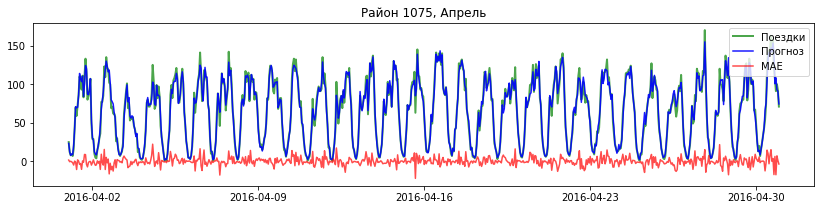

In [10]:
layout1     = Layout(width='180px')
prm_button1 = widgets.Button(description=u'Показать', layout = layout1)
prm_reg1    = widgets.Dropdown(options=list(data_regs)    , value=dic_prms1['region'], description=u'Район' , layout=layout1)
prm_month1  = widgets.Dropdown(options=dic_val_mon        , value=dic_prms1['month'] , description=u'Месяц' , layout=layout1)
prm_day1    = widgets.Dropdown(options=list(range(1,31+1)), value=dic_prms1['day']   , description=u'День'  , layout=layout1)    
prm_hour1   = widgets.Dropdown(options=list(range(1,24+1)), value=dic_prms1['hour']  , description=u'Час'   , layout=layout1)
prm_val1    = widgets.Dropdown(options=dic_val1, value=dic_prms1['val']              , description=u'Данные', layout=layout1)
prm_info1   = widgets.Dropdown(options=dic_info, value=dic_prms1['info']             , description=u'Инфо'  , layout=layout1)
prm_list1   = [prm_button1, prm_reg1, prm_month1, prm_day1, prm_hour1, prm_val1, prm_info1]
prm_container1 = widgets.HBox()
prm_container1.children = [i for i in prm_list1]

display(prm_container1)

m = show_map_data()    
display(m)

fig1, ax1 = plt.subplots(figsize=(14,3))
show_reg_data(ax1)

def prm_button1_on_click(sender):
        
    clear_output(wait=True) #очищаем предыдущее изображение  

    #!!! ВНИМАНИЕ: На разных компьютерах разное поведение ipywidgets, поэтому:
    #1) Если при нажатии "Показать" пропадает панель с параметрами, то надо открыть строку display(prm_container1) 
    #2) Если при нажатии "Показать" панель с параметрами дублируется, то надо закоментить строку display(prm_container1) 
    display(prm_container1) 

    m = show_map_data()
    display(m)          #рисуем карту
    
    show_reg_data(ax1)
    display(fig1)       #рисуем график
    
def prm_month1_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms1['month'] = change['new']
def prm_day1_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms1['day'] = change['new']
def prm_hour1_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms1['hour'] = change['new']
def prm_val1_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms1['val'] = change['new']
def prm_info1_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms1['info'] = change['new']
def prm_reg1_on_cnaghe(change): 
    if change['type']=='change' and change['name'] == 'value': dic_prms1['region'] = change['new']
        
prm_button1.on_click(prm_button1_on_click)
prm_reg1.observe(prm_reg1_on_cnaghe)
prm_month1.observe(prm_month1_on_cnaghe)
prm_day1.observe(prm_day1_on_cnaghe)
prm_hour1.observe(prm_hour1_on_cnaghe)
prm_val1.observe(prm_val1_on_cnaghe)
prm_info1.observe(prm_info1_on_cnaghe)

### ВЫВОД по презентации


   Презентация с помощью IPYWIDGETS работает достаточно неплохо. Однако отсутствие ясных механизмов управления выводом порождает непонятные эффекты. Вывод иногда не показываетя, иногда показывается два раза, доработка кода для получения нужного эффекта иногда напоминает шаманство. К тому же на разных экранах отображение параметров значительно отличается.
   
   Я не стал использовать holoview, т.к. во втором задании был показан Folium map, возникла идея использовать его. Как выяснилось, есть ряд ограничений по выводу данных на карте и возможностям привязки обработчиков к областям. Для реализации функционала вывода значений использовал маркеры. Выбор района пришлось делать через параметры.

   По-видимому, для нормального инетрактивного анализа данных лучше использовать аналитические системы, в которых параметры и отображаемые компоненты естественным образом объеденины в единую технологию.
   
   Если интерактиная часть почему-то не заработет, прикладываю несколько скриншотов.